## Insurance claims analysis and prediction

#### Task description:
***
The goal is to analyze and create a PoC which predicts if a customer makes an insurance claim. Paying out when a customer makes one is by a substantial margin the biggest cost to any insurer, so it’s important the policies are priced sufficiently highly to cover this cost. However, charging too much will result in customers taking their business elsewhere. Being able to differentiate between high- and low-risk customers allows for applying adequate policies to customers. In order to do so, machine learning models were created which predict how probable it is for a customer to make a claim based on their driving style and characteristics. 

#### Task approach:
***
- Understanding and analysis of the original dataset
- Visualization of the most important findings
- Preprocessing before modelling
- Modelling
- Evaluation

#### Data:
***
Each row in the dataset corresponds to a customer/policy, the outcome column corresponds to whether they made a claim or not, and the other columns describe the customer, their vehicle or their driving style. Most of the columns are self-explanatory, but noting additionally that: DUI means Driving Under the Influence of Alcohol, telematic_score is a driving score created with help of telematics devices mounted in vehicles.

In [177]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
from sklearn.metrics import confusion_matrix

In [178]:
org_data = pd.read_csv('source/data.csv')

print('Dataset shape:',org_data.shape)
with pd.option_context('display.max_columns', None):
    display(org_data.head())

Dataset shape: (10000, 21)


,id,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome,telematic_score,monthly_mileage
0,569520,65+,female,majority,0-9y,high school,high,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,False,37.454012,1000.000000
1,750365,16-25,male,majority,0-9y,none,very low,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,True,95.071431,1333.333333
2,199901,16-25,female,majority,0-9y,high school,low,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,False,73.199394,916.666667
3,478866,16-25,male,majority,0-9y,university,low,0.206013,True,before 2015,False,True,32765,11000.0,sedan,0,0,0,False,59.865848,916.666667
4,731664,26-39,male,majority,10-19y,none,low,0.388366,True,before 2015,False,False,32765,12000.0,sedan,2,0,1,True,15.601864,1000.000000


### Exploratory Data Analysis

In [3]:
org_data.describe()

,id,credit_score,postal_code,annual_mileage,speeding_violations,DUIs,past_accidents,telematic_score,monthly_mileage
count,10000.000000,9018.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000,9043.000000
mean,500521.906800,0.515813,19864.548400,11697.003207,1.482900,0.23920,1.056300,49.415956,974.750267
std,290030.768758,0.137688,18915.613855,2818.434528,2.241966,0.55499,1.652454,28.763013,234.869544
min,101.000000,0.053358,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.001163,166.666667
25%,249638.500000,0.417191,10238.000000,10000.000000,0.000000,0.00000,0.000000,24.632887,833.333333
50%,501777.000000,0.525033,10238.000000,12000.000000,0.000000,0.00000,0.000000,49.252862,1000.000000
75%,753974.500000,0.618312,32765.000000,14000.000000,2.000000,0.00000,2.000000,74.000635,1166.666667
max,999976.000000,0.960819,92101.000000,22000.000000,22.000000,6.00000,15.000000,99.971767,1833.333333


Text(0, 0.5, 'Number of cases')

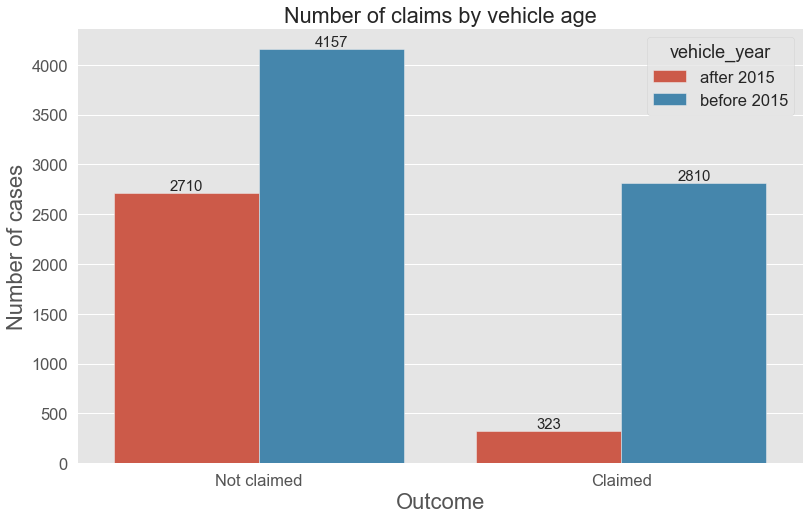

In [179]:
# Main points visualization
plt.style.use('ggplot')

fig,ax = plt.subplots(figsize=(13,8))
plt.rcParams.update({'font.size': 15})

org_data['Outcome'] = np.where(org_data['outcome'], 'Claimed', 'Not claimed')
ax = sns.countplot(data=org_data, x='Outcome', hue='vehicle_year')

for bars in ax.containers:
    ax.bar_label(bars)
plt.title('Number of claims by vehicle age')
plt.xlabel('Outcome', fontsize = 22)
plt.ylabel('Number of cases', fontsize = 22)

The plot presents number of claims made (and not) by available vehicle age.

For over 40% of vehicles older than 2015 a claim has been made. In the case of younger vehicles this is just ~10%. This could be due to various reasons, one of them being that the older cars usually have worse equipment. For example, younger vehicles are often supplied with better traction control and sensors for keeping a car in line. 

As the risk of making a claim is significantly higher for the older vehicles, their premiums should be higher as well.

Text(0, 0.5, 'Number of cases')

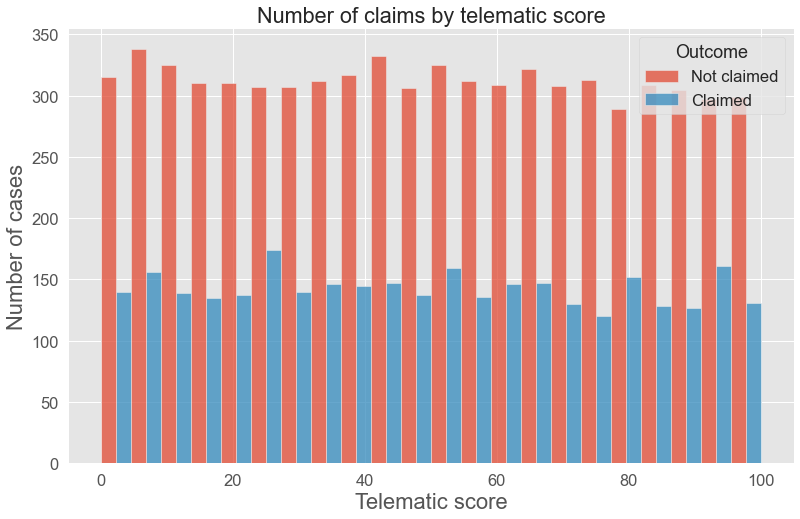

In [180]:
fig,ax = plt.subplots(figsize=(13,8))
plt.rcParams.update({'font.size': 15})
ax = sns.histplot(data=org_data, x='telematic_score', hue='Outcome',multiple='dodge')

plt.title('Number of claims by telematic score')
plt.xlabel('Telematic score', fontsize = 22)
plt.ylabel('Number of cases', fontsize = 22)

Interestingly, the telematic score does not seem to have any effect on the claims. For vast majority of scores the claims oscillate around 30% of all cases. That would suggest that the driving style does not impact the number of accidents. This seems counter-intuitive, but it can be explained. One possibility would be malfunctioning or bad telematics devices. If that is the case, the algorithm in these devices should be adjusted or replaced. Second possibility is the randomization of provided data, in which case it is not possible to say more until more records are provided.  

Text(0, 0.5, 'Number of cases')

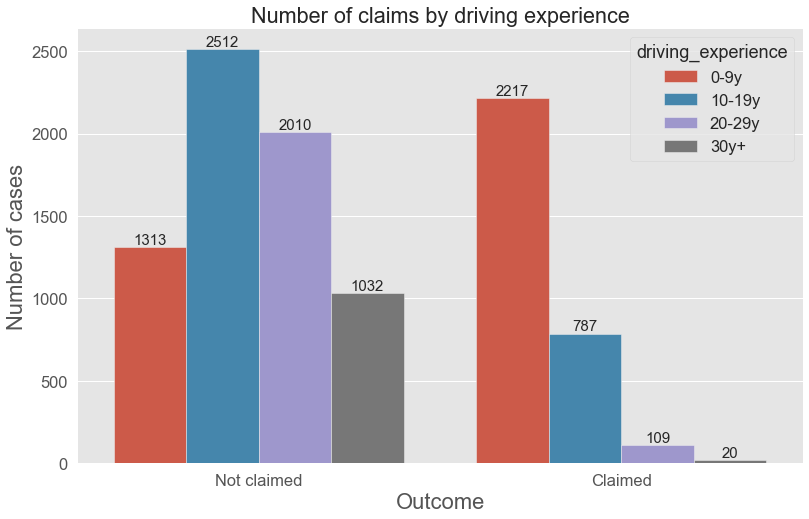

In [141]:
fig,ax = plt.subplots(figsize=(13,8))
plt.rcParams.update({'font.size': 15})
ax = sns.countplot(data=org_data, x='Outcome', hue='driving_experience')

for bars in ax.containers:
    ax.bar_label(bars)
plt.title('Number of claims by driving experience')
plt.xlabel('Outcome', fontsize = 22)
plt.ylabel('Number of cases', fontsize = 22)

Not only a clear majority of claims (70%) is done by drivers with short experience (<9 years), but also over 60% of all of these drivers made a claim in the last year. This shows that young drivers (in terms of experience, not age) are more risky for a company and their premium should be higher.

Claims per credit score

In [144]:
# Cumulative % of claims and sum of entities per Credit Score
ents = []
perc_claim_per_cr_score = []
cr_scores_list = [x/100 for x in range (1,100)]
for cr_sc in cr_scores_list:
    ents.append(sc.count().max())
    sc = org_data[org_data.credit_score<=cr_sc]
    try:
        sc_score = sc['outcome'].value_counts(normalize=True).to_frame().T[True][0]
        perc_claim_per_cr_score.append(round(sc_score, 3))
    except:
        perc_claim_per_cr_score.append(0)

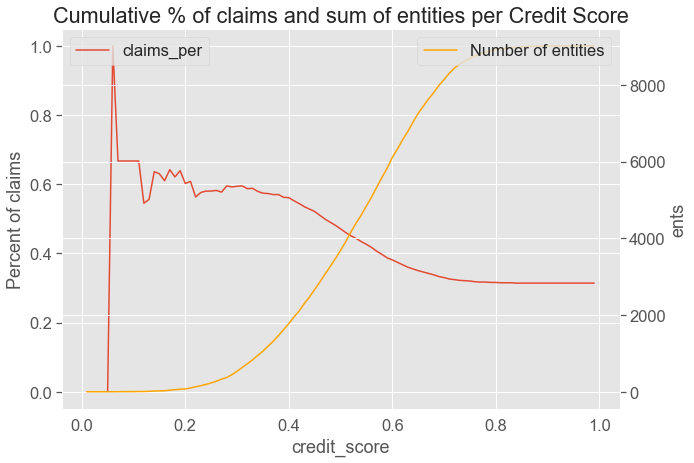

In [145]:
df1 = pd.DataFrame({'credit_score': cr_scores_list, 'claims_per': perc_claim_per_cr_score})
df2 = pd.DataFrame({'credit_score': cr_scores_list, 'ents': ents})

fig, ax = plt.subplots()

# First plot
ax.plot(df1['credit_score'], df1['claims_per'], label='claims_per')
ax.set_xlabel('credit_score')
ax.set_ylabel('Percent of claims')

# Second plot
ax2 = ax.twinx()
ax2.plot(df2['credit_score'], df2['ents'], label='Number of entities', color='orange')
ax2.set_ylabel('ents')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Cumulative % of claims and sum of entities per Credit Score')
plt.show()

The chart shows how much percent of customers with a credit score smaller or equal x have made a claim, and additionally how many customers were there with the credit_score <= x. For example, for the credit_score <= 0.2, 60% of customers have made a claim, but the overall number of them is barely above 0. The number of customers with a minor or close to the maximum score is small, but this might be related to methodology of their calculation and more details on that would be needed for a full assessment. Also, unsuprisingly, the more high-score entities are analysed, the smaller the percent of claims become.  

### Model Preprocessing
***
To create a model, firstly data has to be preprocessed. In this task the goal is to predict if a customer will make a claim or not, which is a binary label, 1-0. For this purpose a supervised classification would be a good choice to start with. Models chosen here are Random Forest and XGBoost, both proven to be very effective and working and returning good results on various classification problems. 

But fitting these models requires necessary preprocessing steps. The following steps here are: correlation matrix check, to understand if the features carry a similar information; missing values check; train-test split; continuous features scaling and one hot encoding categorical variables, as their form has to be changed before they are supplied to the model; Principle Components Analysis (PCA), to decrease the number of features and decrease the chance of overfitting. 

In [181]:
data = org_data.copy()
# switching label to 1-0 
data['outcome'] = np.where(data['outcome'], 1, 0) 
# dropping unrelevant columns
data = data.drop(['id', 'Outcome'], axis = 1) 

In [9]:
data.head(3)

,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome,telematic_score,monthly_mileage
0,65+,female,majority,0-9y,high school,high,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,0,37.454012,1000.000000
1,16-25,male,majority,0-9y,none,very low,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,1,95.071431,1333.333333
2,16-25,female,majority,0-9y,high school,low,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,0,73.199394,916.666667


In [182]:
# Checking unique values of categorical columns
cat_cols = ['age', 'gender', 'race', 'driving_experience', 'education', 'income', 'vehicle_ownership', 
            'vehicle_year', 'married', 'children', 'postal_code', 'vehicle_type']

for x in data[cat_cols].columns:
    print('Column: {}, number of unique categories: {}'.format(x, len(data[x].unique()))) 

# All columns have just a few different values, even the postal codes.

Column: age, number of unique categories: 4
Column: gender, number of unique categories: 2
Column: race, number of unique categories: 2
Column: driving_experience, number of unique categories: 4
Column: education, number of unique categories: 3
Column: income, number of unique categories: 4
Column: vehicle_ownership, number of unique categories: 2
Column: vehicle_year, number of unique categories: 2
Column: married, number of unique categories: 2
Column: children, number of unique categories: 2
Column: postal_code, number of unique categories: 4
Column: vehicle_type, number of unique categories: 2


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'credit_score'),
  Text(1.5, 0, 'annual_mileage'),
  Text(2.5, 0, 'speeding_violations'),
  Text(3.5, 0, 'DUIs'),
  Text(4.5, 0, 'past_accidents'),
  Text(5.5, 0, 'outcome'),
  Text(6.5, 0, 'telematic_score'),
  Text(7.5, 0, 'monthly_mileage')])

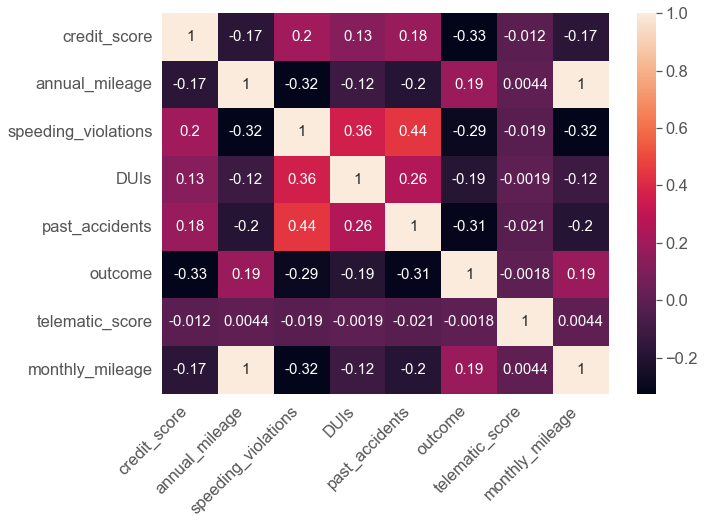

In [175]:
# correlations
plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams.update({'font.size': 15})
# sns.heatmap(data.drop(cat_cols, axis=1).corr(), annot=True)
sns.heatmap(data.drop(cat_cols, axis=1).corr(), annot=True)
plt.xticks(rotation=45, ha='right')

By looking at the correlation matrix, it can be noticed that some features are moderately correlated. For example, there is a small correlation between speeding violations and DUIs, but also a negative small correlation with monthly mileage. Unsuprisingly, the monthly mileage is perfectly correlated with annual mileage. Some features could bring similar information to the models and this is one of the reasons why later PCA will be conducted.

In [62]:
# Missing values 
print('Number of unique rows with missing values:', data.count()[0]-data.dropna().count()[0])
data.isna().sum()

Number of unique rows with missing values: 1851


age                      0
gender                   0
race                     0
driving_experience       0
education                0
income                   0
credit_score           982
vehicle_ownership        0
vehicle_year             0
married                  0
children                 0
postal_code              0
annual_mileage         957
vehicle_type             0
speeding_violations      0
DUIs                     0
past_accidents           0
outcome                  0
telematic_score          0
monthly_mileage        957
dtype: int64

There are three column with missing values in the dataset, with ~1900 unique rows with nulls. There are three ways they can be approached:
- by dropping these rows. By decreasing the amount of available data for modelling, less information can be provided for models, but sometimes it might be the only way;
- by imputing missing values. Imputation allows to find an approximation of the missing observation, which then allows using rows with nulls. This is useful if such row contains valuable information which should be provided into the model, if the missing value is easy to predict or simply if there are many similar rows. However, wrong approach to imputation might disrupt final results; 
- by not including columns with missing information in further steps, if a column is proven to be unuseful.

For a PoC, as the goal of this task is to explore if an ML approach makes sense in the first place, the rows with blanks are dropped for now. 

In [183]:
data = data.dropna()

#### Train-test split

In [13]:
data.head(3)

,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome,telematic_score,monthly_mileage
0,65+,female,majority,0-9y,high school,high,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,0,37.454012,1000.000000
1,16-25,male,majority,0-9y,none,very low,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,1,95.071431,1333.333333
2,16-25,female,majority,0-9y,high school,low,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,0,73.199394,916.666667


In [14]:
# Data split to training and testing sets. Testing size is 20%
y = data['outcome']
X = data.drop('outcome', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

print('Full table:', X.shape, y.shape)
print('Full table: Numer of claims = {}. Number of nonclaims = {}'.format(y[y==1].count(), y[y==0].count()))
print('Training table:', X_train.shape, y_train.shape)
print('Training table: Numer of claims = {}. Number of nonclaims = {}'.format(y_train[y_train==1].count(), y_train[y_train==0].count()))
print('Testing table:', X_test.shape, y_test.shape)
print('Testing table: Numer of claims = {}. Number of nonclaims = {}'.format(y_test[y_test==1].count(), y_test[y_test==0].count()))

Full table: (8149, 19) (8149,)
Full table: Numer of claims = 2536. Number of nonclaims = 5613
Training table: (6519, 19) (6519,)
Training table: Numer of claims = 2029. Number of nonclaims = 4490
Testing table: (1630, 19) (1630,)
Testing table: Numer of claims = 507. Number of nonclaims = 1123


#### Features scaling, OneHot Encoding

In [15]:
# Features scaling
X_train_cat = X_train[cat_cols]
X_train_con = X_train.drop(cat_cols, axis=1)
X_test_cat = X_test[cat_cols]
X_test_con = X_test.drop(cat_cols, axis=1)

# One Hot Encoding - for categorical variables
ohe = OneHotEncoder()
X_train_cat_enc = ohe.fit_transform(X_train_cat)
X_test_cat_enc = ohe.transform(X_test_cat)

# Standard Scaler - for continuous variables
ssc = StandardScaler()
X_train_con_enc = ssc.fit_transform(X_train_con)
X_test_con_enc = ssc.transform(X_test_con)

X_tr = pd.concat([pd.DataFrame(X_train_cat_enc.toarray()), pd.DataFrame(X_train_con_enc)], axis=1)
X_te = pd.concat([pd.DataFrame(X_test_cat_enc.toarray()), pd.DataFrame(X_test_con_enc)], axis=1)
print('Training shape: {}./nTesting shape: {}'.format((X_tr.shape), (X_te.shape)))

(6519, 54) (1630, 54)


##### PCA

In [176]:
# Dimensionality reduction. Searching for the optimal number of features
for i in range(1,31):
    pca = PCA(n_components=i)
    X_tr_pca = pca.fit_transform(X_tr)
    X_te_pca = pca.transform(X_te)
    exp_var = np.sum(pca.explained_variance_ratio_)
    if exp_var >= 0.95:
        print('Threshold 0.95 of explained variance met with {} components'.format(i))
        break

Threshold 0.95 of explained variance met with 21 components


As checked above, number of components = 21 explains over 95% of variance present in the features. As checked, an increase to 99% would require adding 7 more features. Just slighlty increasing variance would significantly increase the number of features, thus the chosen number of components is 21. 

In [17]:
pca = PCA(n_components=21)
X_tr_pca = pca.fit_transform(X_tr)
X_te_pca = pca.transform(X_te)

### Modelling
***
The models chosen for the task are Random Forest and XGBoost. RandomizedSearchCV is run to find the best parameters for both models. By testing multiple variations, it finds which parameters return the best scores. While it might give worse results than GridSearchCV or BayesSearchCV, it runs much faster and is a great option to start with. 

For each case a specific score should be maximized. For example, when dealing with some highly imbalanced datasets, the best might be to focus on F1 score, as accuracy would not be telling the whole story. Having 20k observations of one class, but just 100 observations of the second class, the model could easily return a very high accuracy, by giving the first class to every possible tested observation. In the case of the analyzed dataset, the number of nonclaims is about twice bigger than the number of claims. But as it’s important the policies are priced sufficiently highly, not too high and not to small, for this exercise it makes sense to concentrate on the biggest recall and the smallest number of false positives.

Discussion on the models and their scores is at the end of the notebook.

##### Random Forest

In [190]:
[x for x in range (1,100,5)]

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96]

In [191]:
# searching for the best Random Forest parameters
rf_params = {'n_estimators': [x for x in range (100,501,50)],
             'max_features': ['sqrt', 'log2'],
             'max_depth': [x for x in range (1,22,5)],
             'min_samples_split': [2, 5, 7, 10, 15],
             'min_samples_leaf': [1, 2, 4], 
             'bootstrap': [True, False]
             }

gs_rf = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                           param_distributions=rf_params,
                           scoring='roc_auc',
                           cv=5,
                           n_jobs=-1,
                           refit=True,
                           n_iter=10)

gs_rf.fit(X_tr_pca, y_train.to_numpy())

for hyperparam in gs_rf.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 1:],": ", gs_rf.best_params_[hyperparam])


n_estimators :  500
min_samples_split :  5
min_samples_leaf :  4
max_features :  log2
max_depth :  11
bootstrap :  True


In [67]:
# # Optimal parameters returned for RF by RandomizedSearchCV

# gs_rf.best_params_ = {'n_estimators' :  500,
# 'min_samples_split' :  5,
# 'min_samples_leaf' :  4,
# 'max_features' :  'log2',
# 'max_depth' :  11,
# 'bootstrap' :  True}

In [194]:
# Fitting Random Forest
rf_best = RandomForestClassifier(**gs_rf.best_params_, n_jobs=-1, class_weight='balanced')
rf = rf_best.fit(X_tr_pca, y_train.to_numpy())
# Creating prediction
preds = rf.predict_proba(X_te_pca)

In [201]:
def con_mat(y_test, y_to_compare, normalize=False):
  ''' 
  Confusion matrix visualisation
  Params:
  -------
  y_test: true labels
  y_to_compare: labels predicted by model
  normalize: True to normalize and return values as percentages.  
  '''

  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (8,6)

  if normalize == True:
    conf_matrix = confusion_matrix(y_test, y_to_compare, normalize='true')
    sns.heatmap(conf_matrix, annot=True, cmap="Blues")
  else:
    conf_matrix = confusion_matrix(y_test, y_to_compare)
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d')

  plt.xlabel('Predictions', fontsize=20)
  plt.ylabel('Actuals', fontsize=20)
  plt.title('Confusion Matrix', fontsize=20)

<AxesSubplot: xlabel='threshold'>

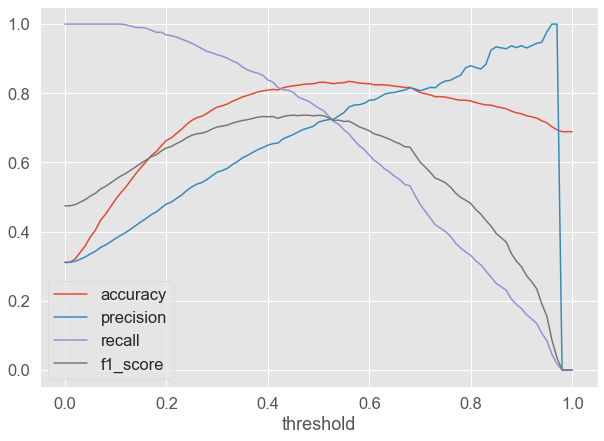

In [196]:
def best_threshold(y_test, preds):
  '''
  Looking for the best cut off point 

  y_test: org y
  preds: model prediction of y
  '''
  scores = {}
  for cutoff in range (0,101):
    cutoff = cutoff/100
    pred = [1 if preds[i][1]>cutoff else 0 for i in range(len(preds))]
    res = confusion_matrix(y_test.to_numpy(), pred)
    
    # accuracy
    acc = (res[0][0]+res[1][1])/res.sum()
    
    # precision
    if res[0][1] ==0 and res[1][1] ==0: prec =0
    else: prec = res[1][1]/(res[0][1]+res[1][1])

    # recall
    if res[1][0] ==0 and res[1][1] ==0: rec =0
    else: rec = res[1][1]/(res[1][0]+res[1][1])

    # f1
    if prec ==0 and rec ==0: f1 =0
    else: f1 = (2*prec*rec/(prec+rec))

    scores[f'{cutoff}'] =  acc, prec, rec, f1
    scores_df = switch_to_pd(scores)
  return scores_df

def switch_to_pd(scores):
  scores_df = pd.DataFrame(scores)

  scores_df = scores_df.transpose()
  scores_df.reset_index(drop=False,inplace=True)
  scores_df.columns = ['threshold', 'accuracy', 'precision', 'recall', 'f1_score']
  return scores_df


scores_df = best_threshold(y_test, preds)
plt.rcParams["figure.figsize"] = (10,7)
scores_df.plot(x='threshold')

The optimal cut-off point, where the precision, recall and f1 meet together, seems to be slighly above 0.5. The same with the accuracy maximum.

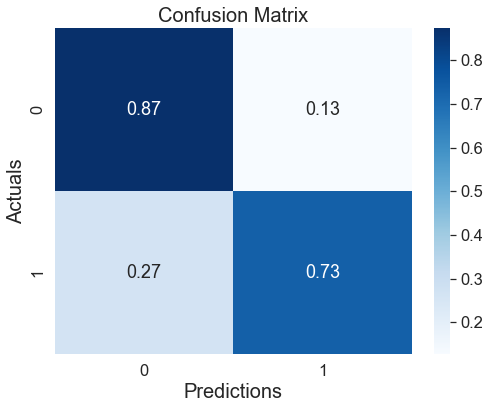

In [202]:
# Cutoff point set as 0.52 based on the above chart. 
cutoff = 0.52 
pred = [1 if preds[i][1]>cutoff else 0 for i in range(len(preds))]

con_mat(y_test.to_numpy(), pred, normalize=True)

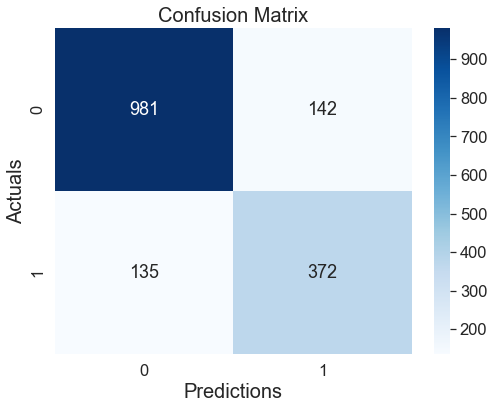

In [203]:
con_mat(y_test.to_numpy(), pred)

In [199]:
# Scores evaluation
for i in [accuracy_score, precision_score, recall_score, f1_score]:
    print(i.__name__, '=', round(i(y_test.to_numpy(), pred),3))

accuracy_score = 0.83
precision_score = 0.724
recall_score = 0.734
f1_score = 0.729


##### XGBoost

In [205]:
# searching for the best XGBoost parameters
param_dist = {'n_estimators': [x for x in range (100,501,50)],
             'gamma': [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4],
             'max_depth': [x for x in range(1,6)],
             'min_child_weight': [x/10 for x in range(0,10)],
             'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
             'lambda': [0, 0.1, 0.3, 0.5, 0.8, 1]
}

clf_xgb = xgb.XGBClassifier()
clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = 5,  
                         n_iter = 5,
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(X_tr_pca, y_train.to_numpy())

for hyperparam in clf.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 1:],": ", clf.best_params_[hyperparam])


Fitting 5 folds for each of 5 candidates, totalling 25 fits
n_estimators :  450
min_child_weight :  0.9
max_depth :  1
learning_rate :  0.3
lambda :  0.3
gamma :  0.4


In [72]:
# # Optimal parameters returned for XGB by RandomizedSearchCV
# clf.best_params_ = {'n_estimators' :  450,
# 'min_child_weight' :  0.9,
# 'max_depth' :  1,
# 'learning_rate' :  0.3,
# 'gamma' :  0.4}

In [206]:
clf_xgb = xgb.XGBClassifier(**clf.best_params_, verbosity=0)   
xgboost = clf_xgb.fit(X_tr_pca, y_train.to_numpy(), verbose=True)

predict_proba = xgboost.predict_proba(X_te_pca)

<AxesSubplot: xlabel='threshold'>

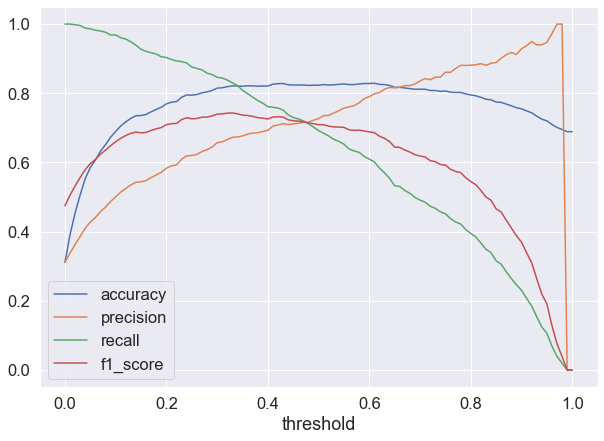

In [207]:
scores_df_xgb = best_threshold(y_test, predict_proba)
plt.rcParams["figure.figsize"] = (10,7)
scores_df_xgb.plot(x='threshold')

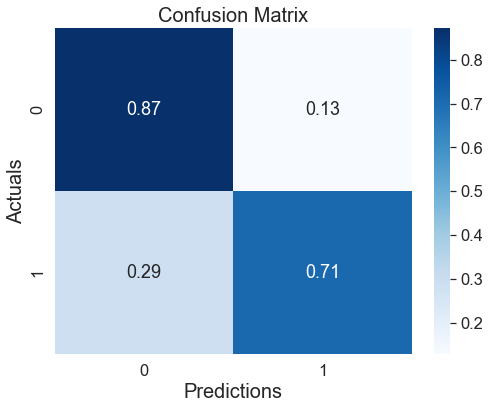

In [208]:
# Running prediciton and preparing confusion matrix
cutoff_xgb = 0.48
xgboost_pred = [1 if predict_proba[i][1]> cutoff_xgb else 0 for i in range(len(predict_proba))]
con_mat(y_test, xgboost_pred, normalize=True)

In [209]:
# Scores evaluation
for i in [accuracy_score, precision_score, recall_score, f1_score]:
    print(i.__name__, '=', round(i(y_test.to_numpy(), xgboost_pred),3))

accuracy_score = 0.823
precision_score = 0.716
recall_score = 0.712
f1_score = 0.714


Random Forest and XGBoost have returned quite similar scores, but Random Forest seems to work a bit better in this situation. This can be noticed by comparing the scores (accuracy ==0.87, f1 >0.7), but also looking at the confusion matrices. RF predicts 88% of True Negatives and 73% of True Positives correctly, while the XGB does so with 87% of TN and 71% of TP.

That means the models are correctly predicting behaviour of 87% of customers, with 71-73% of claims properly highlighted.  


### Improvements ideas
While there is a potential to use these models, the scores can definitely be further improved. The following things could be tested and (probably) make the results better:
- broaden the parameters search: not all possibilities were tested in terms of the parameters, as each additional option scales up the required calculations. Adding more options to the RandomizedSearchCV and using GridSearch or BayesSearch could return a different set, and ultimately improve the final scores; 
- changing approach to missing values: 2k of observations were eliminated because not all data was available. The nulls are present in 3 variables and it would be worth to try different imputation techniques; 
- searching if there are anomalies in the data;
- testing different models. RF and XGB are the most popular ones due to their performance, but the are more possibilites;  
- as with any model, it would be good to give models more data to train - more observations or more features, if possible;
- additionally, the telematics data/devices should be verified. The lack of impact of the driving style on the number of claims is counter-intuitive and there might be some data issues;
